In [1]:
import setigen_patch as stg # some **kwargs, slightly modified plots, add gamma noise
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

/home/obs/.conda/envs/seticore/lib/python3.12/site-packages/blimpy/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
%matplotlib inline

In [3]:
WINDOW_SIZE = 2**10
OUTPUT_FOLDER = "../../deliverables/injected/"
TEST_OUTPUT = "outputs/v2/"

First I'll define MeerKAT band 5b parameters

In [4]:
df = 1 * u.Hz
num_samples = 2**24
# lo, hi = 15.365*u.GHz, 15.38*u.GHz
lo = 15*u.GHz; hi = lo + num_samples*df
center_freq = (lo+hi)/2
bandwidth = (hi-lo)
obs_time = 300 * u.s
n_ints = 16
# df = bandwidth / num_samples
dt = obs_time / n_ints

dt, df.to(u.Hz), lo, hi, bandwidth

(<Quantity 18.75 s>,
 <Quantity 1. Hz>,
 <Quantity 15. GHz>,
 <Quantity 15.01677722 GHz>,
 <Quantity 0.01677722 GHz>)

In [9]:
frame = stg.Frame(
    fchans=num_samples,
    tchans=n_ints,
    df=df,
    dt=dt,
    fch1=hi,
    dtype=np.float32
)

## Add Noise
### $T_\text{rx}$
for this we have the inequality given in the technical specification:
$$ T_\text{rx} < 10.6 + 0.633\,(\nu - 8.41) $$
at frequency $\nu$. We will treat this as an equality in order to make a worst-scenario estimate

In [10]:
T_rx = lambda nu: 10.6*u.K + 0.633 * (nu - 8.41*u.GHz) * (u.K/u.GHz)

### $T_\text{sky}$

Which is $T_\text{atm} + T_\text{gal} + T_\text{cmb}$ namely the contributions are from respectively atmospheric emission, galactic synchrotron background and cosmic microwave background.

In [11]:
T_sky = lambda nu: 568*u.K * (nu / u.GHz)**-1.13 # galactic center 

In [12]:
T_sys = lambda nu: T_rx(nu) + T_sky(nu)

### Power and error

In [13]:
def power(nu):
    k_B = 1.38e-23 * (u.J/u.K)
    R = 50 * u.Ohm
    P = k_B * T_sys(nu) * frame.df * u.Hz
    P = P.to(u.yW)
    
    N = (frame.df*u.Hz * frame.dt*u.s).to(u.dimensionless_unscaled)

    return P, N
P, N = power(center_freq)

In [14]:
f"Power: {P :.4g} ± {P/np.sqrt(N) :.4g} over {N :.4g} samples"

'Power: 571.2 yW ± 131.9 yW over 18.75 samples'

In [15]:
noise = frame.add_noise(k=(N/2).value, theta=(2*P/N).value, noise_type='gamma')

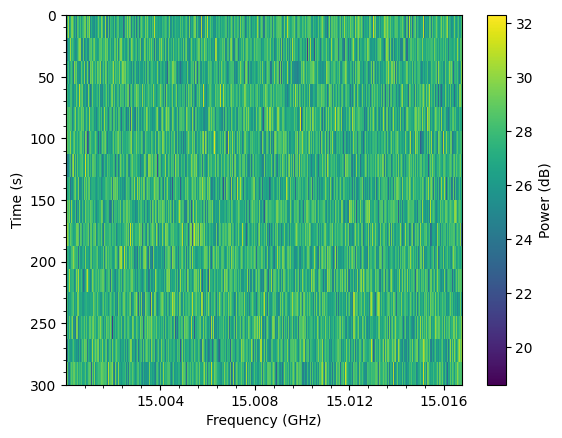

In [16]:
frame.plot('f', minor_ticks=True, db=True, funits="GHz", fdownsample=2**10)

In [17]:
def add_signal(frame, mean_freq, dr, snr, width):
    f_start = mean_freq - dr*frame.data.shape[0]*frame.dt*u.s/2
    
    return frame.add_signal(
        stg.constant_path(f_start=f_start,
                          drift_rate=dr),
        stg.constant_t_profile(level=frame.get_intensity(snr=snr)),
        stg.gaussian_f_profile(width=width),
        stg.constant_bp_profile(level=1)
    )

In [18]:
midf = 15.004*u.GHz ; dr  = 1.5 * (u.Hz/u.s);
width=1*u.Hz       ; snr = 30*u.dimensionless_unscaled

In [19]:
signal = add_signal(frame, midf, dr, snr, width)

In [20]:
frame_s = frame.get_slice(
    (f := frame.get_index(frequency=midf)) - WINDOW_SIZE//2,
    f + WINDOW_SIZE//2
)

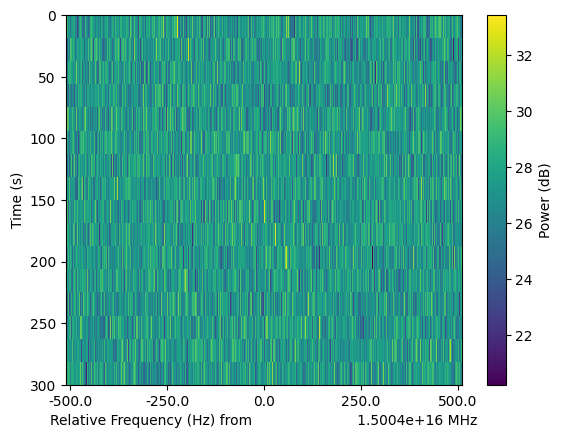

In [21]:
frame_s.plot()

In [22]:
frame.data.dtype = np.float32

In [23]:
frame.save_h5(OUTPUT_FOLDER + "meerKAT_high_30.h5")

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/meerKAT_high_30.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 1.71sec


both seticore and turboSETI find the hit:

In [24]:
!HDF5_PLUGIN_PATH=/home/obs/.conda/envs/seticore/lib/python3.12/site-packages/hdf5plugin/plugins seticore {OUTPUT_FOLDER+"meerKAT_high_30.h5"}

welcome to seticore, version 1.0.6
running in dedoppler mode.
loading input from ../../deliverables/injected/meerKAT_high_30.h5
dedoppler parameters: max_drift=10.00 min_drift=0.0000 snr=25.00
writing output to ../../deliverables/injected/meerKAT_high_30.dat
hit: coarse channel = 12, index = 194529, snr = 28.50984, drift rate = 1.50044 (-422 bins)
dedoppler elapsed time: 4s


In [25]:
!turboSETI -g y {OUTPUT_FOLDER+"meerKAT_high_30.h5"}


turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.1
HDF5 library version 1.12.2


data_handler    INFO     From blimpy, n_coarse_chan=16
HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 15016.777215999999, 'foff': -1e-06, 'ibeam': -1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 16777216, 'nifs': 1, 'rawdatafile': 'Synthetic', 'source_name': 'Synthetic', 'src_dej': <Angle -28.3831 deg>, 'src_raj': <Angle 17.7875 hourangle>, 'telescope_id': 6, 'tsamp': 18.75, 'tstart': 60869.65465742104, 'za_start': 0.0}

Starting ET search with parameters: datafile=../../deliverables/injected/meerKAT_high_30.h5, max_drift=10.0, min_drift=1e-05, snr=25.0, out_dir=./, coarse_chans=, flagging=False, n_coarse_chan=16, kernels=None, gpu_id=0, gpu_backend=True, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_

## A lot of them

In [67]:
from time import perf_counter as pc
def make_and_save(*args,
                  signal_per_file=1,
                  num_samples=num_samples,
                  n_ints=n_ints,
                  df=df,
                  dt=dt,
                  hi=hi,
                  signal_info_dir="",
                  output_dir="",
                  time_it=False):
    if signal_per_file == 1:
        filename = "_".join(f"{arg.value:.4g}" for arg in args) + ".h5"
    else:
        filename = str(hash(str(args))) + ".h5"
        with open(signal_info_dir+filename+".npy", 'wb') as f:
            np.save(f, args)
    print(f"{filename} running on process {multiprocessing.current_process().name}")
    if time_it:
        print("Creating Frame...", end=" ")
        start = pc()
    frame = stg.Frame(
        fchans=num_samples,
        tchans=n_ints,
        df=df,
        dt=dt,
        fch1=hi,
        dtype=np.float32,
    )
    if time_it:
        print(f"{pc() - start} s")
        print("Calculating Noise parameters... ", end=" ")
        step = pc()
    P, N = power(np.atleast_1d(args[0]).mean()) # mid frequency
    if time_it:
        print(f"{pc() - step} s")
        print("Adding Noise... ", end=" ")
        step = pc()
    noise = frame.add_noise(
        k=(N/2).value,
        theta=(2*P/N).value,
        noise_type='gamma'
    )
    for i in range(signal_per_file):
        if time_it:
            print(f"{pc() - step} s")
            print("Adding Signal... ", end=" ")
            step = pc()
        signal = add_signal(frame, *[arg[i] for arg in args])
    if time_it:
        print(f"{pc() - step} s")
        print("Saving File... ", end=" ")
        step = pc()
    frame.save_h5(output_dir + filename)
    if time_it:
        print(f"{pc() - step} s")
        print(f"\nTOTAL : {pc() - start} s")
    return filename

In [68]:
M_lo, M_hi = 8.3 * u.GHz, 15.4 * u.GHz
DR_lo, DR_hi = .01*(u.Hz/u.s), 5*(u.Hz/u.s)
logSNR_lo, logSNR_hi = 1, 3
W_lo, W_hi = 1 * u.Hz, 20 * u.Hz
def _make_and_save_random(signal_per_file=1,
                          seed=None,
                          time_it=False,
                          snr_fixed=None, # float
                          width_fixed=None, # astropy quantity (freq)
                          **kwargs):
    rng = np.random.default_rng(seed=seed)
    midf = M_lo + rng.random()*(M_hi - M_lo)
    dr = DR_lo + rng.random(signal_per_file)*(DR_hi - DR_lo)
    dr = np.where(rng.random(signal_per_file)<.5, -dr, dr)
    if snr_fixed is not None:
        snr = snr_fixed * np.ones(signal_per_file)
    else:
        snr = 10**(logSNR_lo + rng.random(signal_per_file)*(logSNR_hi - logSNR_lo)) * u.dimensionless_unscaled
    if width_fixed is not None:
        width = width_fixed * np.ones(signal_per_file)
    else:
        width = W_lo + rng.random(signal_per_file) * (W_hi - W_lo)
    df=1*u.Hz; n_samples=2**22; n_ints=16
    obstime = 300*u.s; dt = obstime / n_ints
    f_hi = midf + df*(n_samples>>1) 

    midF = midf + (rng.random(signal_per_file)-.5)*n_samples*df
    output_filename = make_and_save(
        midF, dr, snr, width,
        signal_per_file=signal_per_file,
        num_samples=n_samples,
        n_ints=n_ints,
        df=df, dt=dt, hi=f_hi,
        time_it=time_it,
        **kwargs 
    )
    print(f"Process {multiprocessing.current_process().name} made file {output_filename}")

In [39]:
_make_and_save_random(
    signal_per_file=2,
    time_it=True,
    signal_info_dir=OUTPUT_FOLDER + "signals/",
    output_dir=OUTPUT_FOLDER + "files/",
)

../../deliverables/injected/signals/
../../deliverables/injected/files/
-4397004959206968840.h5 running on process MainProcess
Creating Frame... 1.3558281138539314 s
Calculating Noise parameters...  0.000989086925983429 s
Adding Noise...  2.071074489504099 s
Adding Signal...  2.829182107001543 s
Adding Signal...  2.845042757689953 s
Saving File...  blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for ../../deliverables/injected/files/-4397004959206968840.h5 without blobbing.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     Conversion time: 0.47sec
0.4773470275104046 s

TOTAL : 9.580572728067636 s
Process MainProcess made file -4397004959206968840.h5


In [47]:
import multiprocessing
import time

def worker(counter, lock, max_iterations, kwargs):
    while True:
        with lock:
            if counter.value >= max_iterations:
                break
            counter.value += 1
            current_iteration = counter.value
        _make_and_save_random(**kwargs)

def make_and_save_random(num_cpus=10, **kwargs):
    max_iterations = 22_831 # about 5TB

    # Shared value and lock for synchronization
    counter = multiprocessing.Value('i', 0)  # shared integer
    lock = multiprocessing.Lock()

    processes = []
    for _ in range(num_cpus):
        p = multiprocessing.Process(target=worker, args=(counter, lock, max_iterations, kwargs))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    print("All processes completed.")

In [ ]:
make_and_save_random(
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "files/",
    signal_info_dir=TEST_OUTPUT + "signals/"
)

5453342529940331820.h5 running on process Process-111
-4643960848534296721.h5 running on process Process-112
8747934723334557792.h5 running on process Process-113
3188515054903884942.h5 running on process Process-114
-6302417694655493170.h5 running on process Process-115
-3705791362549522356.h5 running on process Process-116
7009252639319302811.h5 running on process Process-119
-2571012879555770323.h5 running on process Process-121
699224159518614854.h5 running on process Process-117
1236571609469238629.h5 running on process Process-118
-8699263971166991717.h5 running on process Process-120
2048999020618363859.h5 running on process Process-122


## see if seticore detected the signal

In [41]:
from pathlib import Path

out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "files"
seticore_dir = out_dir / "seticore"
signal_dir = out_dir / "signals"

In [42]:
def show_found_signal(fr, midf, dr, midf2=None, dr2=None):
    if midf2 is None: midf2=midf
    if dr2 is None: dr2=dr
    i_min = fr.get_index(frequency=min(midf, midf2)*u.GHz) - WINDOW_SIZE//2
    i_max = fr.get_index(frequency=max(midf, midf2)*u.GHz) + WINDOW_SIZE//2
    frame_s = fr.get_slice(i_min, i_max)
    frame_s.plot(ftype="f", funits="GHz")
    plt.plot(
        frame_s.ts_ext * dr + midf*1e9 - dr*(150 + frame_s.dt//2),
        frame_s.ts_ext,
        c='k',
        alpha=.4
    )
    plt.plot(
        frame_s.ts_ext * dr2 + midf2*1e9 - dr2*(150 + frame_s.dt//2),
        frame_s.ts_ext,
        c='r',
        alpha=.7
    )
    plt.show()

In [43]:
def check_signal(signal, seticore, frame=None, verbose=False):
    distances = np.linalg.norm((seticore - signal)[:, :1], axis=1)    
    min_index = np.argmin(distances)

    if verbose:
        print(f"{signal = }")
        print(f"Closest row index: {min_index}")
        print(f"{seticore[min_index] = }")
        print(f"Minimum L2 distance: {distances[min_index]}")

    if frame: show_found_signal(frame, *seticore[min_index, :2], *signal[:2])
    return distances[min_index]

In [44]:
def gets_found(*args, **kwargs):
    return check_signal(*args, **kwargs) < 1e-8

In [54]:
SIGNALS = []
def process_file(
    f: Path,
    seticore_dir=seticore_dir,
    signal_dir=signal_dir
):
    seticore_f = seticore_dir / (f.stem + ".dat")
    signals_f  = signal_dir   / (f.name + ".npy")
    assert signals_f.exists(), "numpy array with signal info not found"
    assert seticore_f.exists(), "run seticore on the file first"
    signals = np.load(signals_f).T # cols are [mean_freq, dr, snr, width]
    seticore = np.loadtxt(seticore_f) # 
    seticore_like_signals = np.vstack([
        (seticore[:, 6:8].mean(axis=1) * 1e6 + 150 * seticore[:, 1]) * 1e-9,
        seticore[:, 1],
        seticore[:, 2],
    ]).T
    for s in signals:
        SIGNALS.append(np.array([*s, gets_found(s[:3], seticore_like_signals)]))

In [620]:
for file in files_dir.iterdir():
    process_file(file)

In [592]:
f = files_dir / "2181600055872595243.h5"

In [599]:
frame = stg.Frame(f)

In [593]:
sg = signal_dir / (f.name + ".npy")

In [594]:
st = seticore_dir / (f.stem + ".dat")

In [595]:
sg = (np.load(sg).T)[:, :3]

In [596]:
st = np.loadtxt(st)

In [597]:
st_like_sg = np.vstack([
    (st[:, 6:8].mean(axis=1) * 1e6 + 150 * st[:, 1]) * 1e-9,
    st[:, 1],
    st[:, 2],
]).T

signal = array([ 9.13072577,  1.5690012 , 40.18239468])
Closest row index: 91
seticore[min_index] = array([ 9.13072577,  1.550222  , 51.575344  ])
Minimum L2 distance: 1.3366303619477549e-09


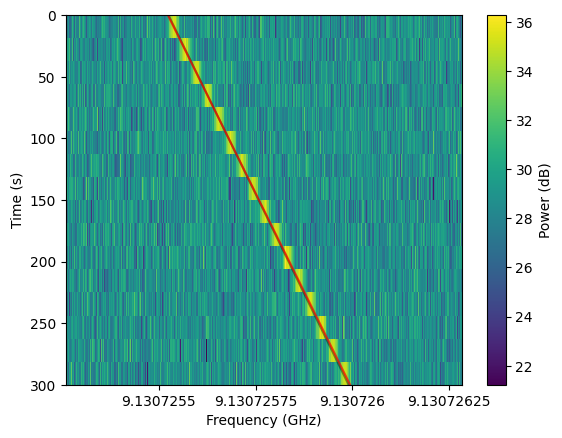

np.float64(1.3366303619477549e-09)

In [600]:
check_signal(sg[89], st_like_sg, frame, verbose=True)

signal = array([ 9.13161005,  1.54309165, 84.48223921])
Closest row index: 38
seticore[min_index] = array([  9.13160714,  -2.830222  , 235.264282  ])
Minimum L2 distance: 2.910932170863134e-06


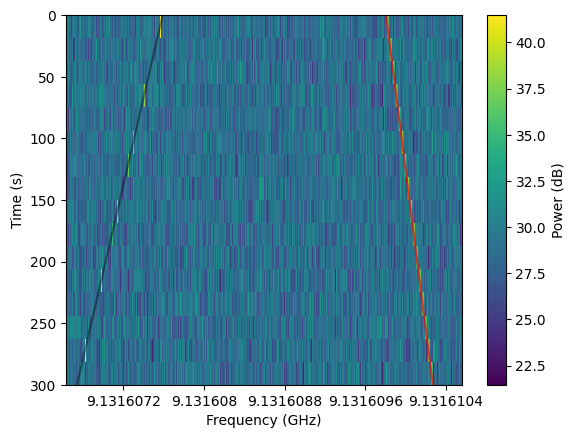

signal = array([ 9.12979111,  0.48498083, 55.94775251])
Closest row index: 148
seticore[min_index] = array([  9.12979325,   2.503111  , 196.7603    ])
Minimum L2 distance: 2.1429970438191503e-06


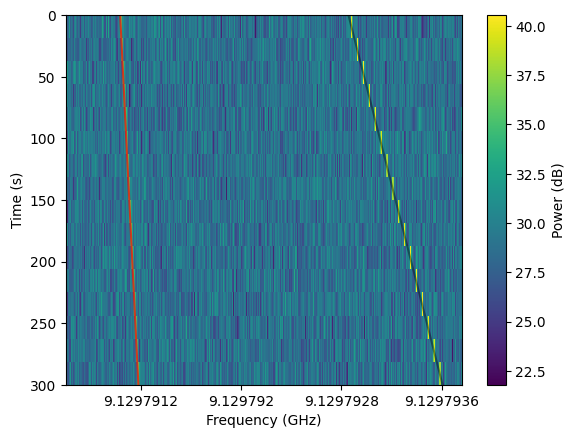

signal = array([ 9.12977458, -3.90802816, 21.41968785])
Closest row index: 149
seticore[min_index] = array([  9.12977625,   4.647111  , 121.959839  ])
Minimum L2 distance: 1.6659700587950965e-06


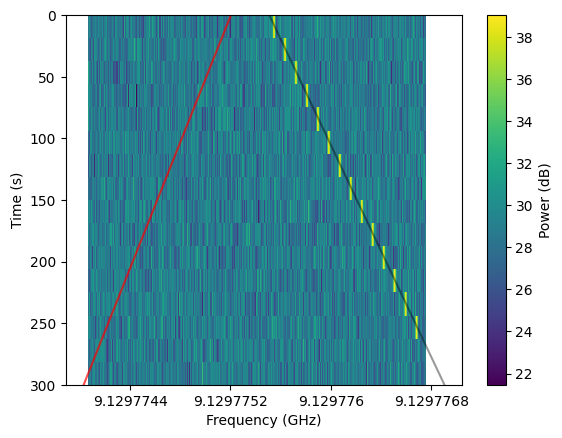

signal = array([ 9.13169025, -4.90788566, 13.5170882 ])
Closest row index: 34
seticore[min_index] = array([  9.13169411,  -1.141333  , 858.043213  ])
Minimum L2 distance: 3.8631928624965894e-06


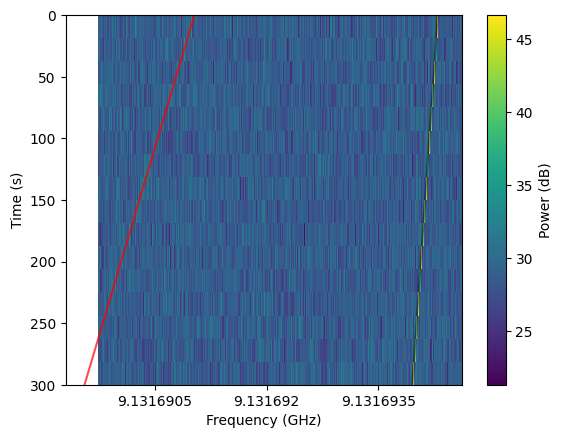

signal = array([ 9.1282213 ,  2.36329528, 88.89468262])
Closest row index: 233
seticore[min_index] = array([   9.12822113,    4.892444  , 1193.604736  ])
Minimum L2 distance: 1.7029041821103874e-07


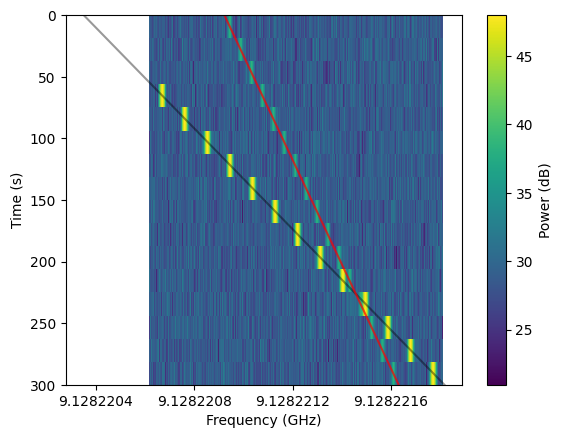

signal = array([ 9.12833511,  0.4881    , 16.96313153])
Closest row index: 226
seticore[min_index] = array([   9.12833556,    4.113778  , 1095.479248  ])
Minimum L2 distance: 4.517659206726421e-07


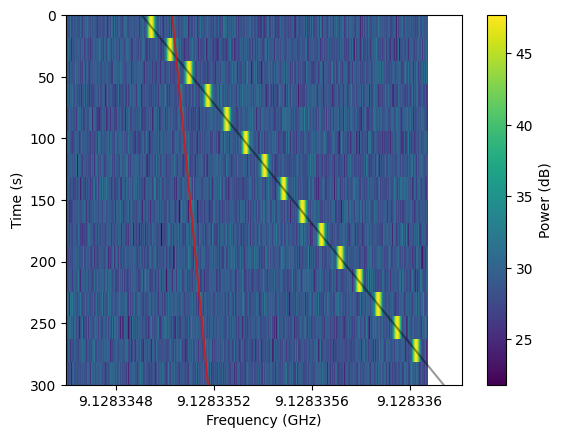

signal = array([  9.12965848,  -2.0744256 , 270.78297904])
Closest row index: 154
seticore[min_index] = array([  9.12965587,  -4.469333  , 790.247986  ])
Minimum L2 distance: 2.610931403523864e-06


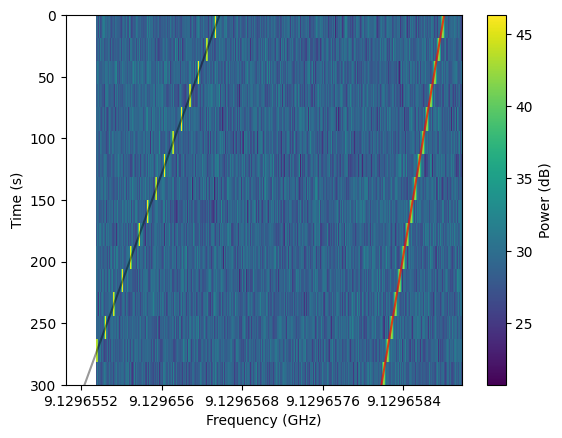

signal = array([  9.13181067,   0.64820746, 210.64341998])
Closest row index: 29
seticore[min_index] = array([  9.13181034,   1.283556  , 277.560944  ])
Minimum L2 distance: 3.276522644313218e-07


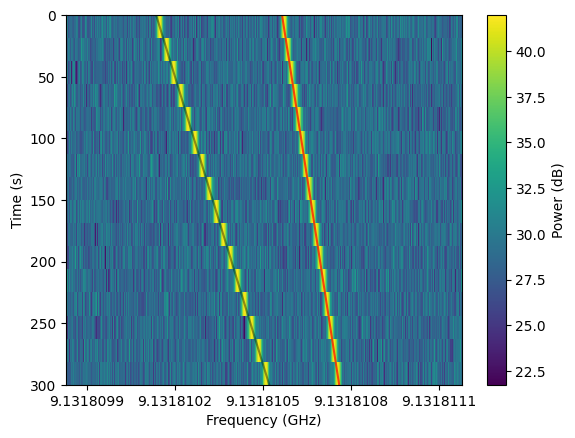

signal = array([ 9.1296708 ,  0.29794715, 19.630875  ])
Closest row index: 152
seticore[min_index] = array([  9.12967178,  -4.352     , 127.869087  ])
Minimum L2 distance: 9.807876537593074e-07


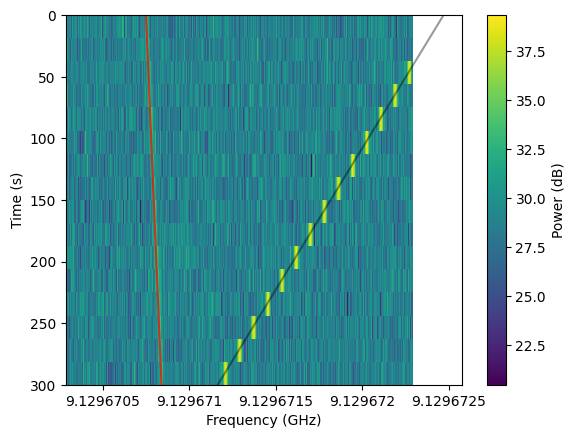

In [601]:
for s in sg:
    if check_signal(s, st_like_sg) > 1e-8:
        check_signal(s, st_like_sg, frame, verbose=True)

## Visualize results

In [623]:
SIGNALS = np.array(SIGNALS)

In [624]:
SIGNALS.shape

(54015, 5)

In [673]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 4061, (7.52%)'

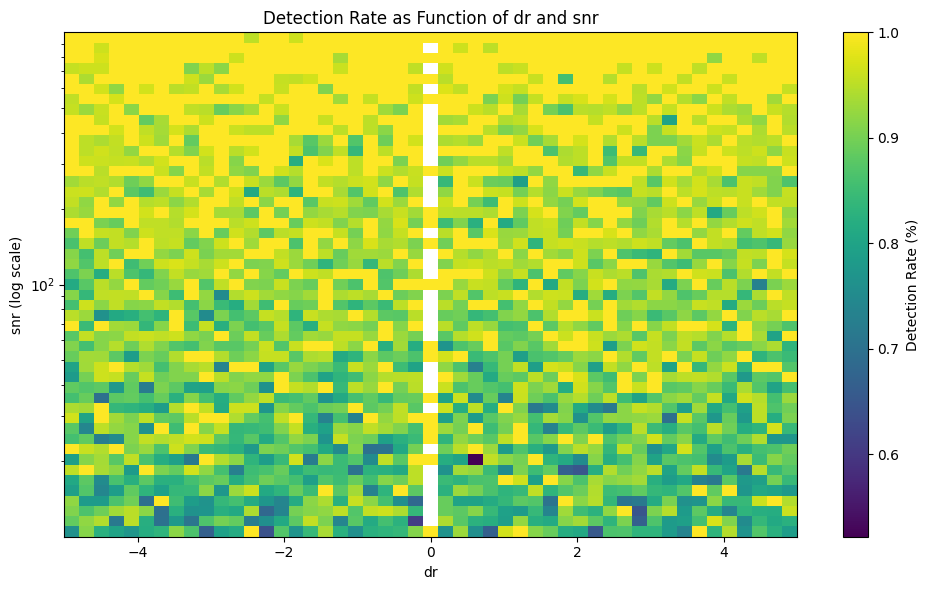

In [674]:
from utils.hist2d import dr_snr, dr_width
dr_snr(SIGNALS)

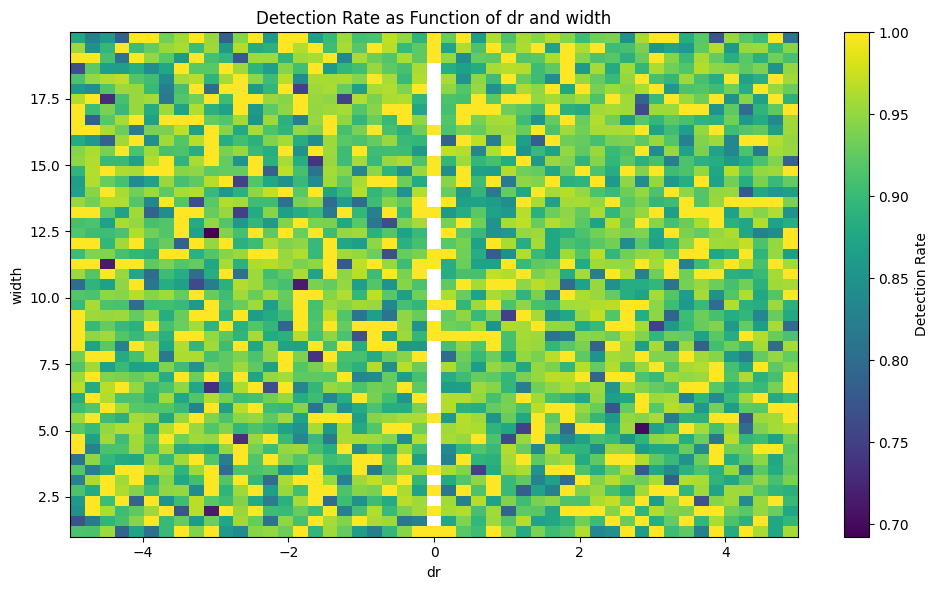

In [675]:
dr_width(SIGNALS)

## Fixed SNR=50

In [13]:
out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "snr-50"
seticore_dir = out_dir / "seticore-snr-50"
signal_dir = out_dir / "signals-snr-50"

In [14]:
SIGNALS=[]

In [15]:
for file in files_dir.iterdir():
    process_file(file)

In [16]:
SIGNALS = np.array(SIGNALS)
SIGNALS.shape

(246300, 5)

In [17]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 16194, (6.57%)'

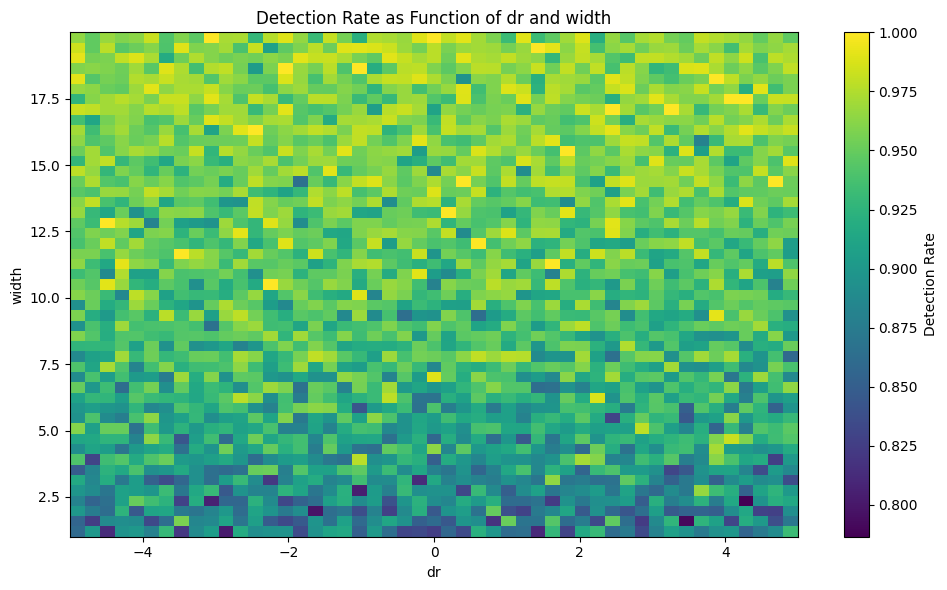

In [18]:
from utils.hist2d import dr_snr, dr_width
dr_width(SIGNALS)

## Fixed width=1Hz

In [ ]:
make_and_save_random(
    num_cpus=16,
    signal_per_file=100,
    output_dir=TEST_OUTPUT + "width-1Hz/",
    signal_info_dir=TEST_OUTPUT + "signals-width-1Hz/",
    width_fixed=1*u.Hz
)

In [49]:
out_dir = Path(TEST_OUTPUT)

files_dir = out_dir / "width-1Hz"
seticore_dir = out_dir / "seticore-width-1Hz"
signal_dir = out_dir / "signals-width-1Hz"

In [58]:
SIGNALS=[]
for file in files_dir.iterdir():
    process_file(file, seticore_dir, signal_dir)
SIGNALS = np.array(SIGNALS)
SIGNALS.shape

(75200, 5)

In [59]:
num_not_found = SIGNALS.shape[0] - SIGNALS[:, 4].sum()
f"{num_not_found = :.0f}, ({100*(num_not_found / SIGNALS.shape[0]) :.3g}%)"

'num_not_found = 5649, (7.51%)'

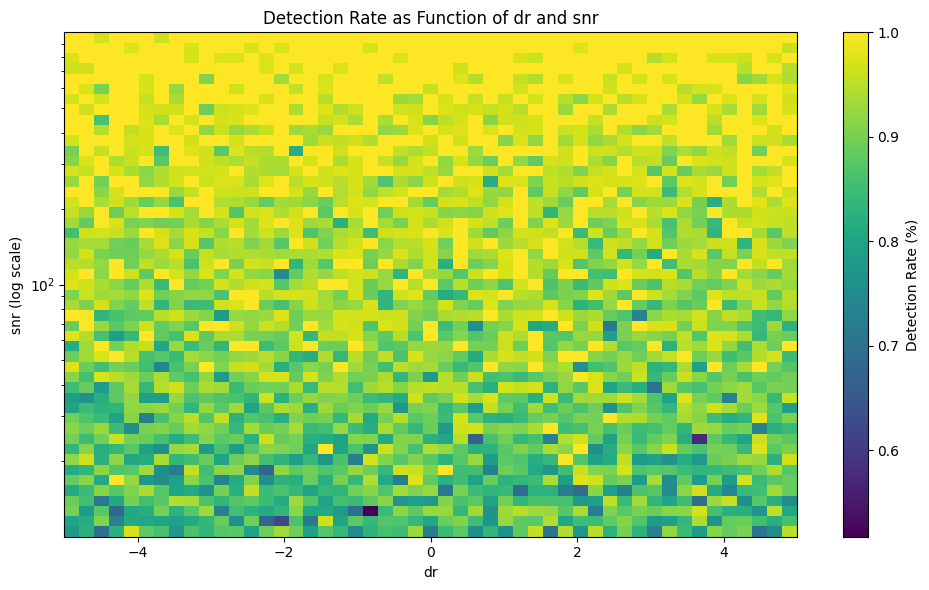

In [60]:
from utils.hist2d import dr_snr
dr_snr(SIGNALS)